In [1]:
# подгружаем все нужные пакеты
import pandas as pd
import numpy as np

# import pandas_profiling as pp

import os
import sys
import math
import string
import itertools as it
from transliterate import translit

from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split

# для встроенных картинок
%pylab inline
# чуть покрасивше картинки:
pd.set_option('display.mpl_style', 'default')
figsize(12, 9)

import warnings
warnings.filterwarnings("ignore")

#plt.rcParams['figure.figsize'] = 10, 7.5
#plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
# import seaborn as sns


import matplotlib as mpl
mpl.rcParams['font.family'] = 'Verdana' # Ubuntu

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

# чтобы был русский шрифт
from matplotlib import rc
 
font = {'family': 'Verdana', #Droid Sans
        'weight': 'normal'}
rc('font', **font)
import pickle as pkl
import random

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
pd.options.display.max_colwidth = 100

In [3]:
import gzip

In [22]:
import folium

## Reading

In [4]:
df_orders_drivers = pd.read_csv('./orders_drivers.csv')
df_text_origin    = pd.read_csv('./text_origin.csv')
df_text_dest      = pd.read_csv('./text_dest.csv')
df_orders_riders  = pd.read_csv('./orders_riders.csv')
df_geo_stream     = pd.read_csv('./geo_stream.csv')
df_reviews        = pd.read_csv('./reviews.csv', sep=';')
with gzip.open('./driver_paths.csv.gz') as f:
    df_driver_paths = pd.read_csv(f)

In [5]:
df_orders_drivers.head(3)

,order_gk,order_datetime,driver_gk,order_status,class_type,rider_total_cost,paid_with_prepaid,payment_type,ride_type,m_ride_duration,ride_distance_key,m_driver_wait_time,m_rating,rider_ftp_date_key,rider_main_device_desc,driver_ftp_date_key,driver_device_platform,total_loyalty_points,acquisition_channel_desc
0,173965,2017-09-25 18:36:01.000000,1137,Completed,Standard,586.00,NaN,Voucher,business,1281.0,5.8,7.0,NaN,2012-10-05,unknown,2016-12-01,Android,105,COMPANY
1,782457,2017-09-15 09:14:38.000000,1137,Completed,Economy,542.37,NaN,Voucher,business,2000.0,16.5,120.0,4.0,2017-04-28,iOS,2016-12-01,Android,4855,MOBILE
2,647029,2017-09-25 16:15:15.000000,1137,Completed,Standard,435.59,NaN,Voucher,business,1171.0,9.1,362.0,NaN,2017-04-11,iPhone,2016-12-01,Android,2285,COMPANY


In [6]:
df_orders_riders.head(3)

,order_gk,order_datetime,rider_gk,order_status,class_type,rider_total_cost,paid_with_prepaid,payment_type,ride_type,m_ride_duration,ride_distance_key,m_driver_wait_time,m_rating,rider_ftp_date_key,rider_main_device_desc,driver_ftp_date_key,driver_device_platform,total_loyalty_points,acquisition_channel_desc
0,376885,2017-09-21 21:30:53.000000,9444,Cancelled,Standard,NaN,NaN,Voucher,business,NaN,NaN,NaN,NaN,2017-07-01,Android,2017-04-18,Android,1285,NaN
1,11150,2017-09-27 09:49:42.000000,9444,Completed,Standard,856.0,NaN,Voucher,business,3179.0,28.3,150.0,NaN,2017-07-01,Android,2017-06-15,iOS,1285,NaN
2,251087,2017-09-21 21:32:04.000000,9444,Completed,Standard,601.0,NaN,Voucher,business,1868.0,13.9,513.0,NaN,2017-07-01,Android,2017-06-16,Android,1285,NaN


In [7]:
df_text_origin.head(3)

,order_gk,hour_key,weekday_key,origin_full_address,origin_latitude,origin_longitude
0,529274,15,3,"Юбилейный проспект, д.74а, Химки",55.894901000000004,37.410573
1,161095,19,0,"МЕГА Теплый Стан, Калужское шоссе 21км, Сосенское",55.604228000000006,37.491983000000005
2,179230,23,6,"метро Станция Аннино, Москва",55.583367,37.596692


In [8]:
df_text_dest.head(3)

,order_gk,hour_key,weekday_key,dest_full_address,dest_latitude,dest_longitude
0,218541,18,4,"Шмитовский пр-д, д.8, п.1, Москва",55.759159,37.553269
1,561549,15,5,"Ходынский бульвар, д.4, Moskwa",55.790046,37.530881
2,64270,11,0,"ул. Онежская, д.36, Москва",55.859218000000006,37.510026


In [9]:
df_geo_stream.head(3)

,drivergk,latitude,longitude,status,gps_at,speed
0,4176,55.925782,37.516895,busy,2017-09-01 14:47:53,2.361546
1,7104,55.625518,37.417599,in_order,2017-09-01 14:47:57,25.859999
2,7104,55.625425,37.417235,in_order,2017-09-01 14:47:56,25.210000


In [10]:
df_driver_paths.head(3)

,gps_at,latitude,longitude,status,driver_id
0,2017-11-11T23:59:57.000Z,0.037159,0.015373,busy,1
1,2017-11-11T23:59:58.000Z,0.037159,0.015373,busy,1
2,2017-11-11T23:59:59.000Z,0.037159,0.015373,busy,1


## Explorations

### 1. Orders

In [47]:
df_orders_riders.order_datetime = pd.to_datetime(df_orders_riders.order_datetime)

In [49]:
print(df_orders_riders.order_datetime.min())
print(df_orders_riders.order_datetime.max())

2017-09-01 00:00:00
2017-09-28 23:59:56


In [36]:
riders_dist_count = df_orders_riders.rider_gk.value_counts()

In [43]:
np.percentile(riders_dist_count, 95)

45.0

In [44]:
riders_dist_count[riders_dist_count>45].shape

(1609,)

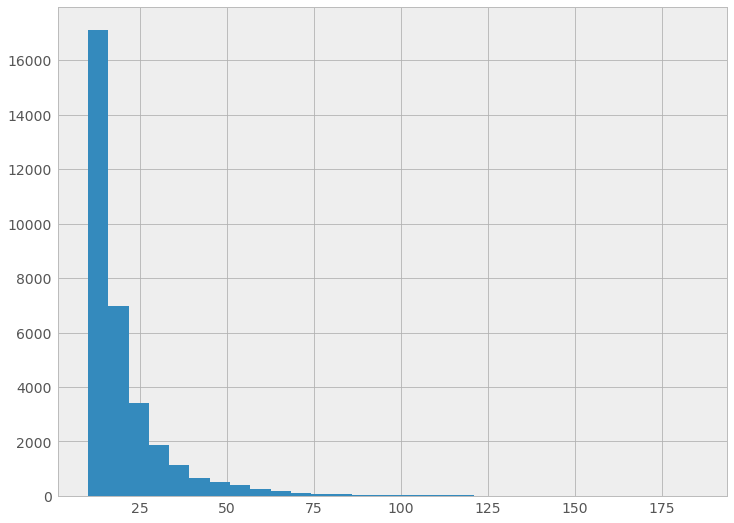

In [41]:
riders_dist_count[riders_dist_count<200].hist(bins=30)

### 2. Geo stream

статусы: ['busy', 'in_order', 'free', 'routing', 'none']

None можно смело выкинуть

In [17]:
df_geo_stream.head()

,drivergk,latitude,longitude,status,gps_at,speed
0,4176,55.925782,37.516895,busy,2017-09-01 14:47:53,2.361546
1,7104,55.625518,37.417599,in_order,2017-09-01 14:47:57,25.859999
2,7104,55.625425,37.417235,in_order,2017-09-01 14:47:56,25.210000
3,7104,55.625332,37.416873,in_order,2017-09-01 14:47:55,24.560000
4,7104,55.625242,37.416523,in_order,2017-09-01 14:47:54,24.070000


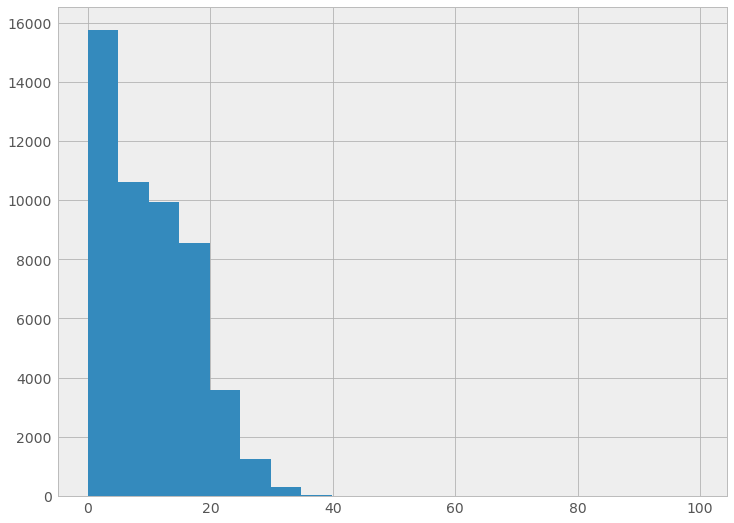

In [62]:
df_geo_stream[df_geo_stream.speed>0].speed.sample(50000).hist(bins=20)

In [12]:
df_geo_stream = df_geo_stream[df_geo_stream.status != 'none']

In [18]:
sizes = df_geo_stream.groupby('drivergk').size()

In [21]:
sizes.median() # медианное количество точек на драйвера

13999.0

In [24]:
df_geo_stream.columns

Index(['drivergk', 'latitude', 'longitude', 'status', 'gps_at', 'speed'], dtype='object')

In [23]:
m_drivers = folium.Map([55.752992, 37.621080], zoom_start=10)

In [88]:
df_geo_test = df_geo_stream.groupby('drivergk').get_group(2)

In [85]:
df_geo_test.shape

(11083, 6)

In [34]:
i = 0
for j, gr in df_geo_stream.groupby('drivergk'):
    points = [tuple(x) for x in gr[['latitude', 'longitude']].values]
    r = lambda: random.randint(0,255)
    folium.PolyLine(points, color='#%02X%02X%02X' % (r(),r(),r()), weight=2.5, opacity=1).add_to(m_drivers)
    i+=1
    if i > 5: break

In [54]:
pd.set_option('float_format', '{:f}'.format)

In [56]:
df_geo_test['ts'] = pd.to_numeric(pd.to_datetime(df_geo_test.gps_at)) / 1000000000

In [72]:
from sklearn.cluster import DBSCAN

In [73]:
clf = DBSCAN()
markers = clf.fit_predict()

In [89]:
coord_test = df_geo_test[['latitude', 'longitude']].as_matrix()

In [99]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [101]:
speed = sc.fit_transform(df_geo_test[['speed']])

(array([ 4312.,  1162.,  1242.,  1349.,  1259.,  1397.,  1556.,   552.,
          412.,   177.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

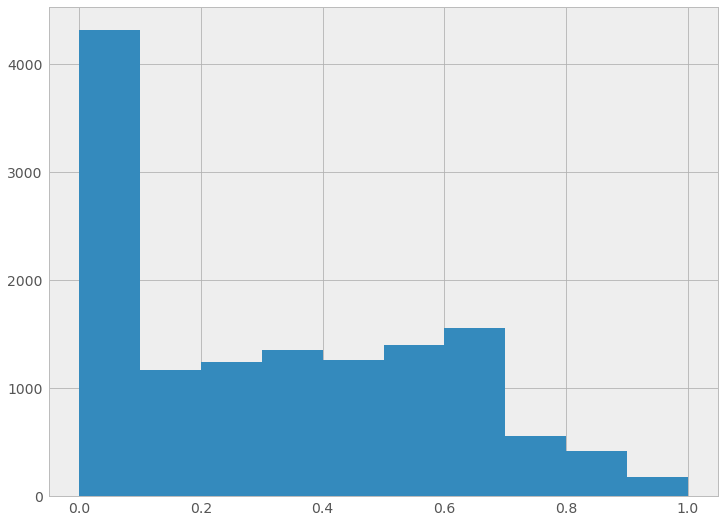

In [115]:
plt.hist(speed)

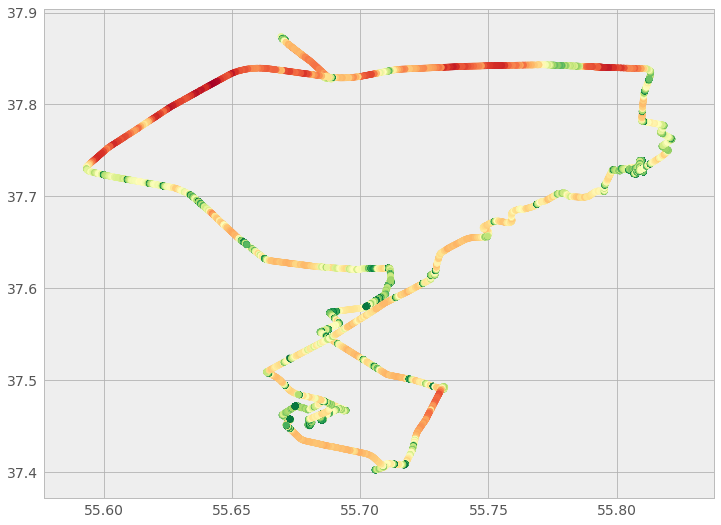

In [116]:
plt.scatter(coord_test[:,0], coord_test[:,1], c=1-speed, cmap=plt.get_cmap('RdYlGn'))

In [103]:
m_driver_test = folium.Map([55.752992, 37.621080], zoom_start=10)
for coord in coord_test:
    folium.CircleMarker(coord, radius=2).add_to(m_driver_test)

m_driver_test.save(os.path.join('maps_html', 'random_driver_stream.html'))

KeyboardInterrupt: 

In [77]:
pd.DataFrame(markers)[0].value_counts()

0    22172
Name: 0, dtype: int64

In [93]:
df_geo_test = df_geo_test.reset_index(drop=True)

In [105]:
import geopy

In [106]:
from geopy.distance import vincenty

In [111]:
m_driver_test = folium.Map([55.752992, 37.621080], zoom_start=10)
points = []

prev_point = df_geo_test.loc[0][['latitude', 'longitude']].values
points+=[prev_point]
for i, point in df_geo_test.iterrows():
    if i==0: 
        continue
    cur_point = point[['latitude', 'longitude']].values
#     if cur_point[2] - prev_point[2] > 20: 
    if vincenty(cur_point, prev_point).km > 0.5:
        r = lambda: random.randint(0,255)
        folium.PolyLine([(p[0], p[1]) for p in points], color='#%02X%02X%02X' % (r(),r(),r()), weight=4.5, opacity=1).add_to(m_driver_test)
        points = [cur_point]
    else:
        points += [cur_point]
    
    prev_point = cur_point

    
if points:
    r = lambda: random.randint(0,255)
    folium.PolyLine([(p[0], p[1]) for p in points], color='#%02X%02X%02X' % (r(),r(),r()), weight=4.5, opacity=1).add_to(m_driver_test)
    
    
m_driver_test.save(os.path.join('maps_html', 'random_driver_stream.html'))

In [112]:
m_drivers.save(os.path.join('maps_html', 'geo_stream_test.html'))

### 3. Driver Paths

In [13]:
df_driver_paths.head()

,gps_at,latitude,longitude,status,driver_id
0,2017-11-11T23:59:57.000Z,0.037159,0.015373,busy,1
1,2017-11-11T23:59:58.000Z,0.037159,0.015373,busy,1
2,2017-11-11T23:59:59.000Z,0.037159,0.015373,busy,1
3,2017-11-11T21:10:01.000Z,0.002748,0.013215,busy,1
4,2017-11-11T21:10:00.000Z,0.002768,0.013144,busy,1


### 4. DF text

In [14]:
df_text_dest.head()

,order_gk,hour_key,weekday_key,dest_full_address,dest_latitude,dest_longitude
0,218541,18,4,"Шмитовский пр-д, д.8, п.1, Москва",55.759159,37.553269
1,561549,15,5,"Ходынский бульвар, д.4, Moskwa",55.790046,37.530881
2,64270,11,0,"ул. Онежская, д.36, Москва",55.859218000000006,37.510026
3,71457,19,4,"улица Бочкова, д.8, к.1, Москва",55.811184999999995,37.632774
4,632664,11,1,"улица Макаренко, д.1, Королев",55.946296999999994,37.907089


In [15]:
df_text_origin.head()

,order_gk,hour_key,weekday_key,origin_full_address,origin_latitude,origin_longitude
0,529274,15,3,"Юбилейный проспект, д.74а, Химки",55.894901000000004,37.410573
1,161095,19,0,"МЕГА Теплый Стан, Калужское шоссе 21км, Сосенское",55.604228000000006,37.491983000000005
2,179230,23,6,"метро Станция Аннино, Москва",55.583367,37.596692
3,569188,8,5,"Можайское шоссе, д.6, Москва",55.722531999999994,37.438834
4,335006,17,2,"Аргуновская улица, д.6, к.1, Москва",55.814663,37.621176
